This notebook will explore an alternative to measuring effective radii of galaxies to compare size ratio distributions. 

## Approach One:

1. find PSFs of W3, W1 images ($\checkmark$)
2. normalize PSFs such that they have the same flux ($\checkmark$ --> used mapping function from sonification project)
3. subtract the two normalized PSFs, which will be the initial kernel guess ($\checkmark$)
4. convolve the 3.4 micron image according to this initial guess to smooth the image ($\checkmark$)
5. use scipy.optimize.minimize to minimize the residual between the convolved 3.4 micron IMAGE and the 12 micron IMAGE; this will iteratively update the convolution kernel until this minimum is achieved (...)
6. apply the optimized convolution kernel to smooth the 3.4 micron image (...)
7. Use the smoothed W1 image to define elliptical apertures
8. Generate COG for W1 image
9. Use the aforementioned apertures to generate COG for W3 image and W3/W1 image (note that W3 is obscured SF only)

#### Postponed indefinitely. Too convoluted for our purposes, no pun intended.

## Approach Two:

1. fit 2D Gaussian to W3 PSF, fit 2D Gaussian to W1 PSF
2. calculate sigmakernel^2 = sigmaw3^2 - sigmaw1^2  (they add in quadrature) 
3. generate 2D PSF with sigmakernel^2
4. Convolve W1 PSF
5. Proceed to step (7) of the first approach!

##### In general: we are assuming our PSFs are approximately Gaussian!

In [417]:
import numpy as np

from astropy.table import Table
from astropy.io import fits
from astropy.visualization import simple_norm
from astropy.coordinates import Angle

from scipy.stats import scoreatpercentile
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import Bounds

#for smoothing the images...I think
from astropy.convolution import convolve, Box2DKernel

from matplotlib import pyplot as plt
%matplotlib inline

import os
homedir = os.getenv("HOME")

from photutils.aperture import EllipticalAperture
from photutils.utils import calc_total_error

from photutils.isophote import EllipseGeometry, Ellipse

# Approach One

In [2]:
#typical sonification mapping function; maps value(s) from one range to another range; returns floats
#I will be using this function to map W3 PSF values to the range of W1 PSF values
#(I assume the mapping of W1 to W3 would also be fine.)
def map_value(value, min_value, max_value, min_result, max_result):
    result = min_result + (value - min_value)/(max_value - min_value)*(max_result - min_result)
    return result

In [3]:
#EXAMPLE, for funsies.
map_value(np.array([0,1,2,3,4,5]), 0, 5, 0, 1)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

In [4]:
#cutout images
w1_im = fits.getdata(homedir+'/vf_html_w1/all_input_fits/NGC3683-custom-image-W1.fits')
w3_im = fits.getdata(homedir+'/vf_html_w1/all_input_fits/NGC3683-custom-image-W3.fits')

#psf images
w1_psf = fits.getdata(homedir+'/vf_html_w1/all_input_fits/NGC3683-custom-psf-W1.fits')
w3_psf = fits.getdata(homedir+'/vf_html_w1/all_input_fits/NGC3683-custom-psf-W3.fits')

In [5]:
min_w1psf, max_w1psf = np.min(w1_psf), np.max(w1_psf)
min_w3psf, max_w3psf = np.min(w3_psf), np.max(w3_psf)

In [87]:
#this will cause the PSF pixel values for both psf images be the same. 
mapped_w3psf = map_value(w3_psf, min_w3psf, max_w3psf, min_w1psf, max_w1psf)

In [142]:
mapped_w3im = map_value(w3_im, np.min(w3_im), np.max(w3_im), np.min(w1_im), np.max(w1_im))

We now have w1_psf and mapped_w3psf. subtract the two to generate an "initial PSF guess" 

- This result represents the additional blurring difference between the two images. We want to match the W1 blurring to the W3 blurring, so knowing this difference and then MINIMIZING IT is crucial.

In [44]:
np.shape(psf_diff)

(325, 325)

In [88]:
#psf_diff = np.abs(w3_psf/np.max(w3_psf) - w1_psf/np.max(w1_psf))
psf_diff = np.abs(mapped_w3psf - w1_psf)

In [281]:
psf_diff_trim = psf_diff[150:175,150:175]   #fewer pixels/parameters to iterate over, centered on PSF

In [90]:
#(note: the two functions below are courtesy of the Internet.)

In [156]:
#convolve W1 image to generate blurring guess, then calculate the residual
#this function is the input argument for scipy.optimize.minimize
iter_list=[]
def calc_residual(kernel):
    reshaped_kernel = kernel.reshape(int(np.sqrt(len(kernel))),int(np.sqrt(len(kernel))))
    smoothed_w1 = convolve(w1_im, reshaped_kernel)
    iter_list.append(np.sum((smoothed_w1 - w3_im)**2))
    #print(np.sum((smoothed_w1 - w3_im)**2)*1e-12)
    #print(kernel)
    return np.sum((smoothed_w1 - w3_im)**2)  #if difference is low for all px, then sum will be low

In [157]:
#the loop function which shall find the minimized/optimized kernel!
#i.e., the function will halt when it has found the kernel which minimizes the calc_residual output
def minimize_residual(initial_kernel, w3_im, w1_im):
    optimized_kernel = minimize(calc_residual, initial_kernel.flatten(),
                                bounds=Bounds(np.min(w1_psf),np.max(w1_psf)),
                                options={'disp': False ,'eps' : 5e-3})
    return optimized_kernel.x

In [158]:
optimized_kernel = minimize_residual(psf_diff_trim, w3_im, w1_im)

In [174]:
x=np.arange(0,len(iter_list))

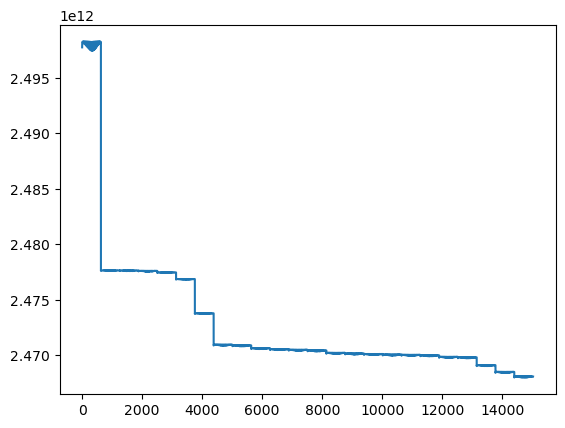

In [175]:
plt.plot(x,iter_list)

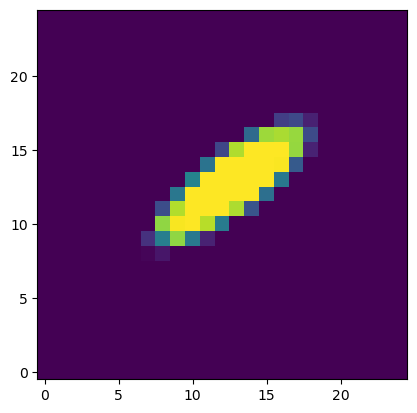

In [183]:
plt.imshow(optimized_kernel.reshape(int(np.sqrt(len(optimized_kernel))),int(np.sqrt(len(optimized_kernel)))),
           origin='lower')

In [271]:
#well, this is fascinating. and not at all desireable. The optimize function incorrectly assumed
#that the way to minimize residuals was to choose a "PSF" which is comparable in shape to the actual
#galaxy image!

---

## Approach Two --> Fitting Gaussians

For ease of access, I copy-paste the steps here.

1. fit 2D Gaussian to W3 PSF, fit 2D Gaussian to W1 PSF
2. calculate sigmakernel^2 = sigmaw3^2 - sigmaw1^2  (they add in quadrature) 
3. generate 2D PSF with sigmakernel^2
4. Convolve W1 PSF
5. Proceed to step (7) of the first approach!

In [187]:
from astropy.modeling import models, fitting

In [251]:
fit_t = fitting.LevMarLSQFitter()

In [274]:
amp = np.max(w1_psf)
#sigma = np.std(w1_psf)
sigma = 3     #resulting model STD is too infinitesimal otherwise. Choose a somewhat arbitrary sigma to start.
y_max, x_max = w1_psf.shape

In [275]:
g2 = models.Gaussian2D(amp, x_max/2, y_max/2, sigma, sigma)

In [276]:
yi, xi = np.indices(w1_psf.shape)

In [277]:
g_w1 = fit_t(g2, xi, yi, w1_psf)

/var/folders/gx/q5wqxlgs0rgfm6f87vgxlgyw4s52w0/T/ipykernel_93783/108961475.py:4: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(w1_psf),vmin=-16,vmax=-1,origin='lower')
/var/folders/gx/q5wqxlgs0rgfm6f87vgxlgyw4s52w0/T/ipykernel_93783/108961475.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(g_w1(xi,yi)),vmin=-16,vmax=-1,origin='lower')
/var/folders/gx/q5wqxlgs0rgfm6f87vgxlgyw4s52w0/T/ipykernel_93783/108961475.py:10: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(w1_psf-g_w1(xi,yi)),vmin=-16,vmax=-1,origin='lower')


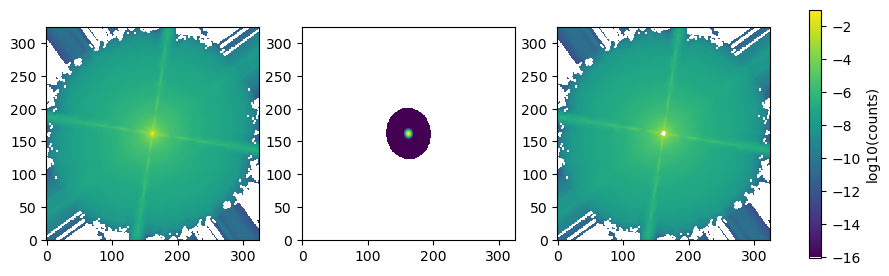

In [320]:
plt.figure(figsize=(10,8))
ax=[]
plt.subplot(1,3,1)
plt.imshow(np.log10(w1_psf),vmin=-16,vmax=-1,origin='lower')
ax.append(plt.gca())
plt.subplot(1,3,2)
plt.imshow(np.log10(g_w1(xi,yi)),vmin=-16,vmax=-1,origin='lower')
ax.append(plt.gca())
plt.subplot(1,3,3)
plt.imshow(np.log10(w1_psf-g_w1(xi,yi)),vmin=-16,vmax=-1,origin='lower')
ax.append(plt.gca())
plt.colorbar(ax=ax,fraction=.016,label='log10(counts)')

plt.show()

/var/folders/gx/q5wqxlgs0rgfm6f87vgxlgyw4s52w0/T/ipykernel_93783/1639992396.py:12: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(w3_psf),vmin=-16,vmax=-1,origin='lower')
/var/folders/gx/q5wqxlgs0rgfm6f87vgxlgyw4s52w0/T/ipykernel_93783/1639992396.py:15: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(g_w3(xi,yi)),vmin=-16,vmax=-1,origin='lower')
/var/folders/gx/q5wqxlgs0rgfm6f87vgxlgyw4s52w0/T/ipykernel_93783/1639992396.py:19: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(w3_psf-g_w3(xi,yi)),vmin=-16,vmax=-1,origin='lower')


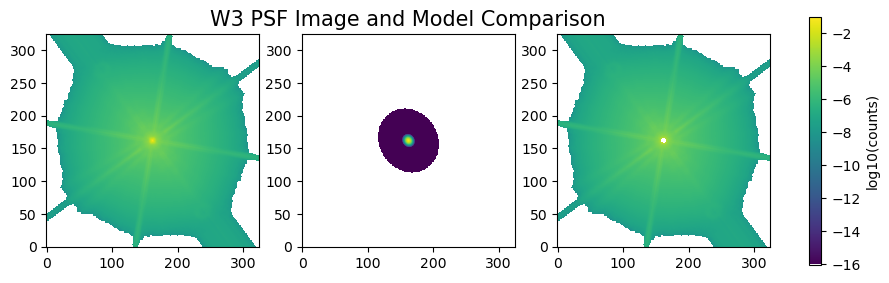

In [321]:
amp = np.max(w3_psf)
#sigma = np.std(w1_psf)
sigma = 3
y_max, x_max = w3_psf.shape
g2 = models.Gaussian2D(amp, x_max/2, y_max/2, sigma, sigma)
yi, xi = np.indices(w3_psf.shape)
g_w3 = fit_t(g2, xi, yi, w3_psf)

plt.figure(figsize=(10,8))
ax=[]
plt.subplot(1,3,1)
plt.imshow(np.log10(w3_psf),vmin=-16,vmax=-1,origin='lower')
ax.append(plt.gca())
plt.subplot(1,3,2)
plt.imshow(np.log10(g_w3(xi,yi)),vmin=-16,vmax=-1,origin='lower')
plt.title('W3 PSF Image and Model Comparison',fontsize=15)
ax.append(plt.gca())
plt.subplot(1,3,3)
plt.imshow(np.log10(w3_psf-g_w3(xi,yi)),vmin=-16,vmax=-1,origin='lower')
ax.append(plt.gca())
plt.colorbar(ax=ax,fraction=.016,label='log10(counts)')

plt.show()

In [259]:
print(g_w3)

Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
         amplitude      x_mean y_mean ...      y_stddev            theta       
    ------------------- ------ ------ ... ------------------ ------------------
    0.05765649107266326  162.0  162.0 ... 1.3454286823320212 0.5873824090694881


In [260]:
print(g_w1)

Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
         amplitude      x_mean y_mean ...      y_stddev             theta       
    ------------------- ------ ------ ... ------------------ -------------------
    0.14195882749845376  162.0  162.0 ... 1.0528714006221478 0.10807240832176654


In [263]:
print(g_w3.x_stddev[0],g_w1.x_stddev[0])

1.1899139477684801 0.9213989220008847


In [267]:
#The STDs are quite similar. WHICH IS NOT SURPRISING, GIVEN THAT THERE IS ONLY A 0.4" DIFFERENCE BETWEEN
#W1 (6.1") AND W3(6.5"). "So...why are are we worrying about this?" Because I was told to, and I remain
#susceptible to accepting instructions without critical thought.

#So, new update --> "do photometry now, then worry about relatively trivial blurring effects."

----

----

# Aperture Photometry

- effective radius might not be strongest metric for investigating processing that 
might be occurring on the galaxy's outskirts.
- we are testing whether the outer radius is sensitive to truncation effects (comparing W3 to W1, then W3/W1)
- entering the arena --> aperture photometry curves of growth!

In [292]:
#let's first display the images, for fun

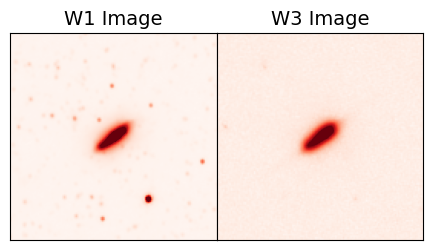

In [317]:
images = [w1_im, w3_im]
titles = ['W1 Image','W3 Image']

percentile1 = 0.5
percentile2 = 99.5

v1 = [scoreatpercentile(w1_im,percentile1),
            scoreatpercentile(w3_im,percentile1)]
v2 = [scoreatpercentile(w1_im,percentile2),
            scoreatpercentile(w3_im,percentile2)]
#v1,v2 = scoreatpercentile(image,[percentile1,percentile2])
norms = [simple_norm(w1_im,'asinh',max_percent=percentile2),
               simple_norm(w3_im,'asinh',max_percent=percentile2)]

plt.figure(figsize=(8,4))
plt.subplots_adjust(wspace=.0)    

for i,im in enumerate(images): 
    ax = plt.subplot(1,3,i+1)
    if i!=2:
        plt.imshow(im,origin='lower',cmap='Reds',norm=norms[i])  #vmin=v1[i],vmax=v2[i]
    plt.tick_params(left=False, bottom=False) 
    ax = plt.gca()
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    plt.title(titles[i],fontsize=14)

In [306]:
#I should also include the mask images sometime...
mask_wise = fits.getdata(homedir+'/vf_html_w1/all_input_fits/NGC3683-custom-image-wise-mask.fits')
bool_mask = np.array(mask_wise,'bool')   #yeesh, I wish I knew this line existed a few months ago.
                                         #converts to 1s (if masked) and 0s (if not masked)

In [311]:
masked_w1 = np.ma.array(w1_im, mask = bool_mask)   #THIS ALSO WOULD HAVE BEEN HELPFUL.
                                                   #cuts out (as if with scissors) masked pixels
masked_w3 = np.ma.array(w3_im, mask = bool_mask)

In [430]:
#I next need some values relating to position angle and B/A for the ellipse. What better way to 
#do so conveniently than to use GALFIT outputs?

#I'll use r-band. or should I use w1? ...w1.

w1_galfit = Table.read(homedir+'/vf_v2_galfit_W1.fits')
axis_ratio = w1_galfit['CBA'][w1_galfit['VFID']=='VFID0901'].value[0]     #convolved version
theta_val = w1_galfit['CPA'][w1_galfit['VFID']=='VFID0901'].value[0]   #converted convolved PA to radians

xc = w1_galfit['CXC'][w1_galfit['VFID']=='VFID0901'].value[0]
yc = w1_galfit['CYC'][w1_galfit['VFID']=='VFID0901'].value[0]         #also applies to w3 image -- center of obj approx center of image
re_px = w1_galfit['CRE'][w1_galfit['VFID']=='VFID0901'].value[0]        #I'll also just use the effective radius to start. there is indeed a hint of irony here.

In [470]:
#I'll also just use the effective radius to start. there is indeed a hint of irony here.
smajor_guess = (re_px) * 1
sminor_guess = (re_px) * axis_ratio

In [471]:
theta = Angle(theta_val, 'deg')
#PA causes ellipse to be rotated 90 degrees relative to galaxy plane...for some reason. So I correct it.
aper = EllipticalAperture((xc, yc),a=smajor_guess, b=sminor_guess, theta=np.deg2rad(theta+Angle(90,'deg')))

(<matplotlib.patches.Ellipse at 0x17c296310>,)

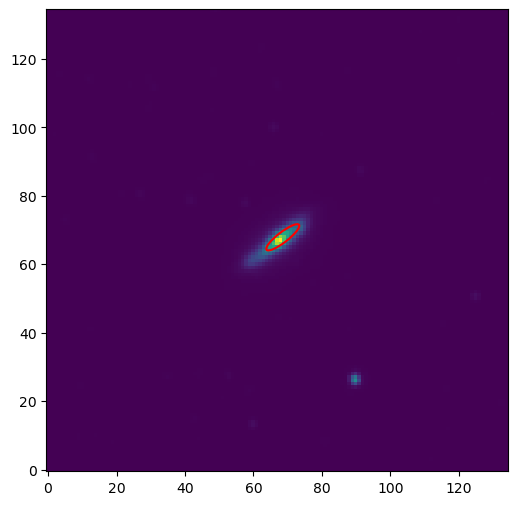

In [472]:
fig,ax = plt.subplots(figsize=(6,6))
plt.imshow(w1_im,origin='lower')
aper.plot(color='red',lw=1.5)

In [489]:
guess_ellipse = EllipseGeometry(x0=xc, y0=yc, sma=smajor_guess, eps=1-(axis_ratio), 
                                pa=np.deg2rad(theta+Angle(90,'deg')).value)

In [490]:
ellipse_fit = Ellipse(masked_w1, guess_ellipse)

In [491]:
isolist = ellipse_fit.fit_image()

In [492]:
isotable = isolist.to_table()

Text(0.5, 1.0, 'VFID0901')

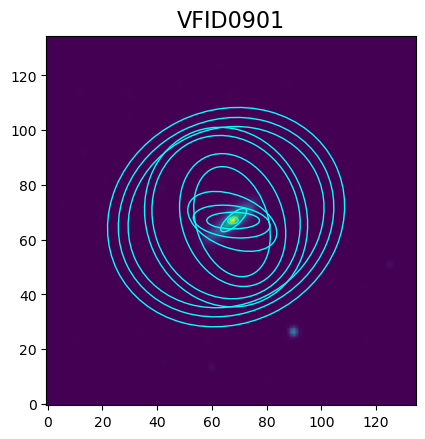

In [499]:
markcolor='cyan'
if len(isolist) > 5:
    smas = np.linspace(np.min(isolist.sma)+2, np.max(isolist.sma),12)
    objlist = []
    for sma in smas:
        iso = isolist.get_closest(sma)
        obj = EllipticalAperture((iso.x0, iso.y0), iso.sma, iso.sma*(1-iso.eps), 
                                theta = np.degrees(iso.pa)) #theta=np.deg2rad(theta+Angle(90,'deg')))
        objlist.append(obj)
plt.imshow(w1_im,origin='lower')
for obj in objlist:
    obj.plot(color=markcolor,lw=1.)
plt.title('VFID0901',fontsize=16)